In [73]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [ ]:
np.random.seed(42)

# A Dummy Dataset

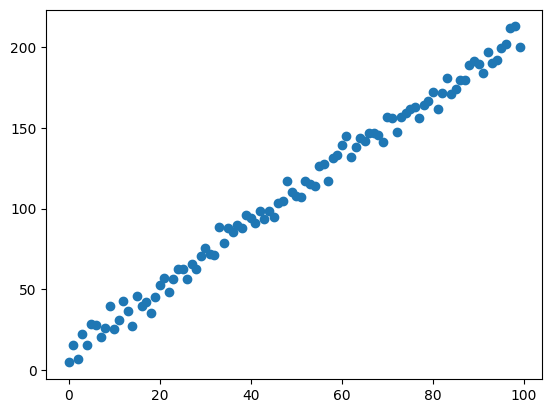

In [ ]:
x = np.arange(100)
np.random.shuffle(x)

k, b = 2, 10
u, s = 0, 5. # gaussian noise

y = k * x + b + [np.random.normal(u, s) for _ in range(x.shape[0])]

plt.scatter(x, y, marker='o')

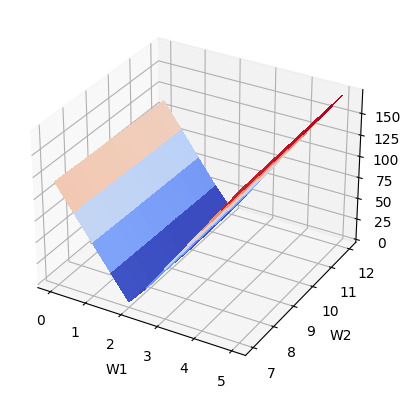

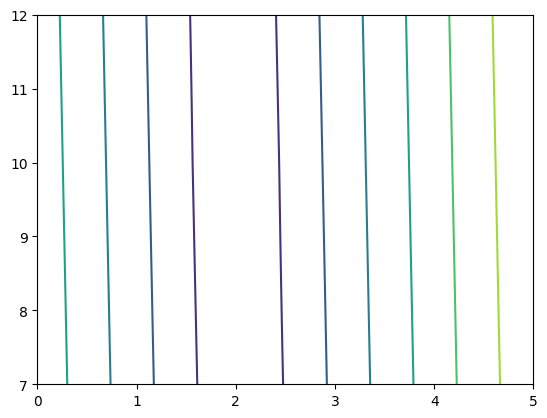

In [ ]:
# Visualize the cost function (something wrong)
from matplotlib import cm

W1, W2 = np.meshgrid(np.linspace(0, 5, 11), np.linspace(7, 12, 11))
W1.shape, W2.shape

loss = np.zeros(W1.shape)
for i in range(W1.shape[0]):
  for j in range(W1.shape[1]):
    w1, w2 = W1[i, j], W2[i, j]
    yhat = x * w1 + w2
    ytrue = x * k + b
    loss[i, j] = np.sqrt(np.mean((yhat-ytrue)**2))
    # print(f'w1:{w1}, w2:{w2}, loss:{loss[i,j]}')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlabel('W1')
ax.set_ylabel('W2')
surf = ax.plot_surface(W1, W2, loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

plt.contour(W1, W2, loss)
plt.show()

## Linear Regression

### Ordinary Least Squares

$ y = (X^\top X)^{-1} (X^\top y) $

See [Introduction to Machine Learning Note 2](https://www.eecs189.org/static/notes/n2.pdf) for reference.

In [ ]:
X = np.ones((x.shape[0], 2))
X[:, 0] = x

w = np.linalg.inv(X.T@X)@(X.T@y)
w


array([ 2.00950674, 10.46932688])

### Ridge Regression

$ y = (X^\top X + \lambda \mathbf{I})^{-1} (X^\top y) $

See [Introduction to Machine Learning Note 2](https://www.eecs189.org/static/notes/n2.pdf) for reference.

In [ ]:
X = np.ones((x.shape[0], 2))
X[:, 0] = x
l = 0.5
w = np.linalg.inv(X.T@X + l*np.identity(2))@(X.T@y)
w

array([ 2.01254445, 10.26762201])

# House Price Prediction

## Dataset

The dataset comes from the Kaggle competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

In [4]:
!unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
   creating: house-prices-advanced-regression-techniques/
  inflating: __MACOSX/._house-prices-advanced-regression-techniques  
  inflating: house-prices-advanced-regression-techniques/test.csv  
  inflating: __MACOSX/house-prices-advanced-regression-techniques/._test.csv  
  inflating: house-prices-advanced-regression-techniques/data_description.txt  
  inflating: __MACOSX/house-prices-advanced-regression-techniques/._data_description.txt  
  inflating: house-prices-advanced-regression-techniques/train.csv  
  inflating: __MACOSX/house-prices-advanced-regression-techniques/._train.csv  
  inflating: house-prices-advanced-regression-techniques/sample_submission.csv  
  inflating: __MACOSX/house-prices-advanced-regression-techniques/._sample_submission.csv  


## Load dataset

In [5]:
dataframe = pd.read_csv('/content/housing-prices/train.csv')
dataframe.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# drop 'Id' column
dataframe = dataframe.drop('Id', axis=1)
dataframe.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Analyze Data

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


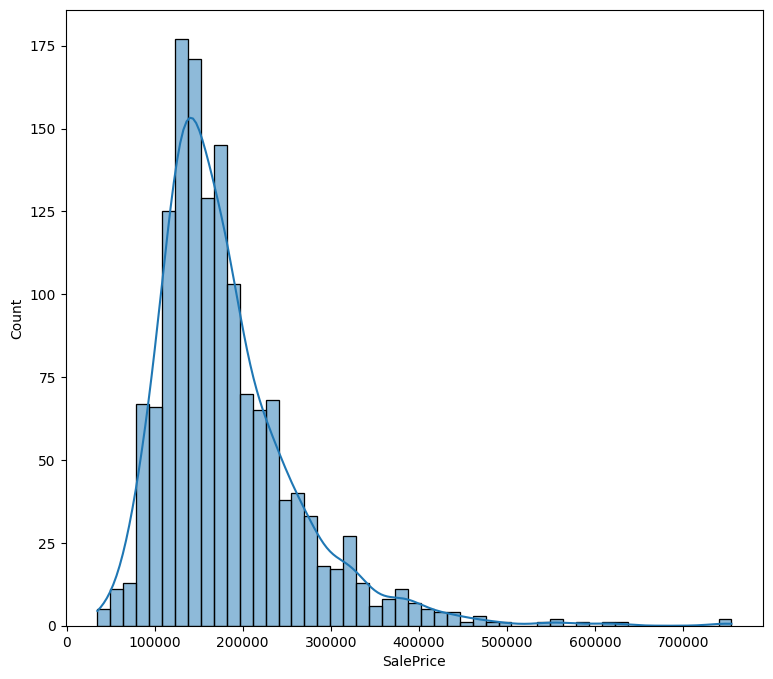

In [16]:
print(dataframe['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(dataframe['SalePrice'], kde=True)

In [ ]:
list(set(dataframe.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [17]:
dataframe_num = dataframe.select_dtypes(include=['float64', 'int64'])
dataframe_num.head()

# dataframe.describe(include=[np.number]) # an alternative

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


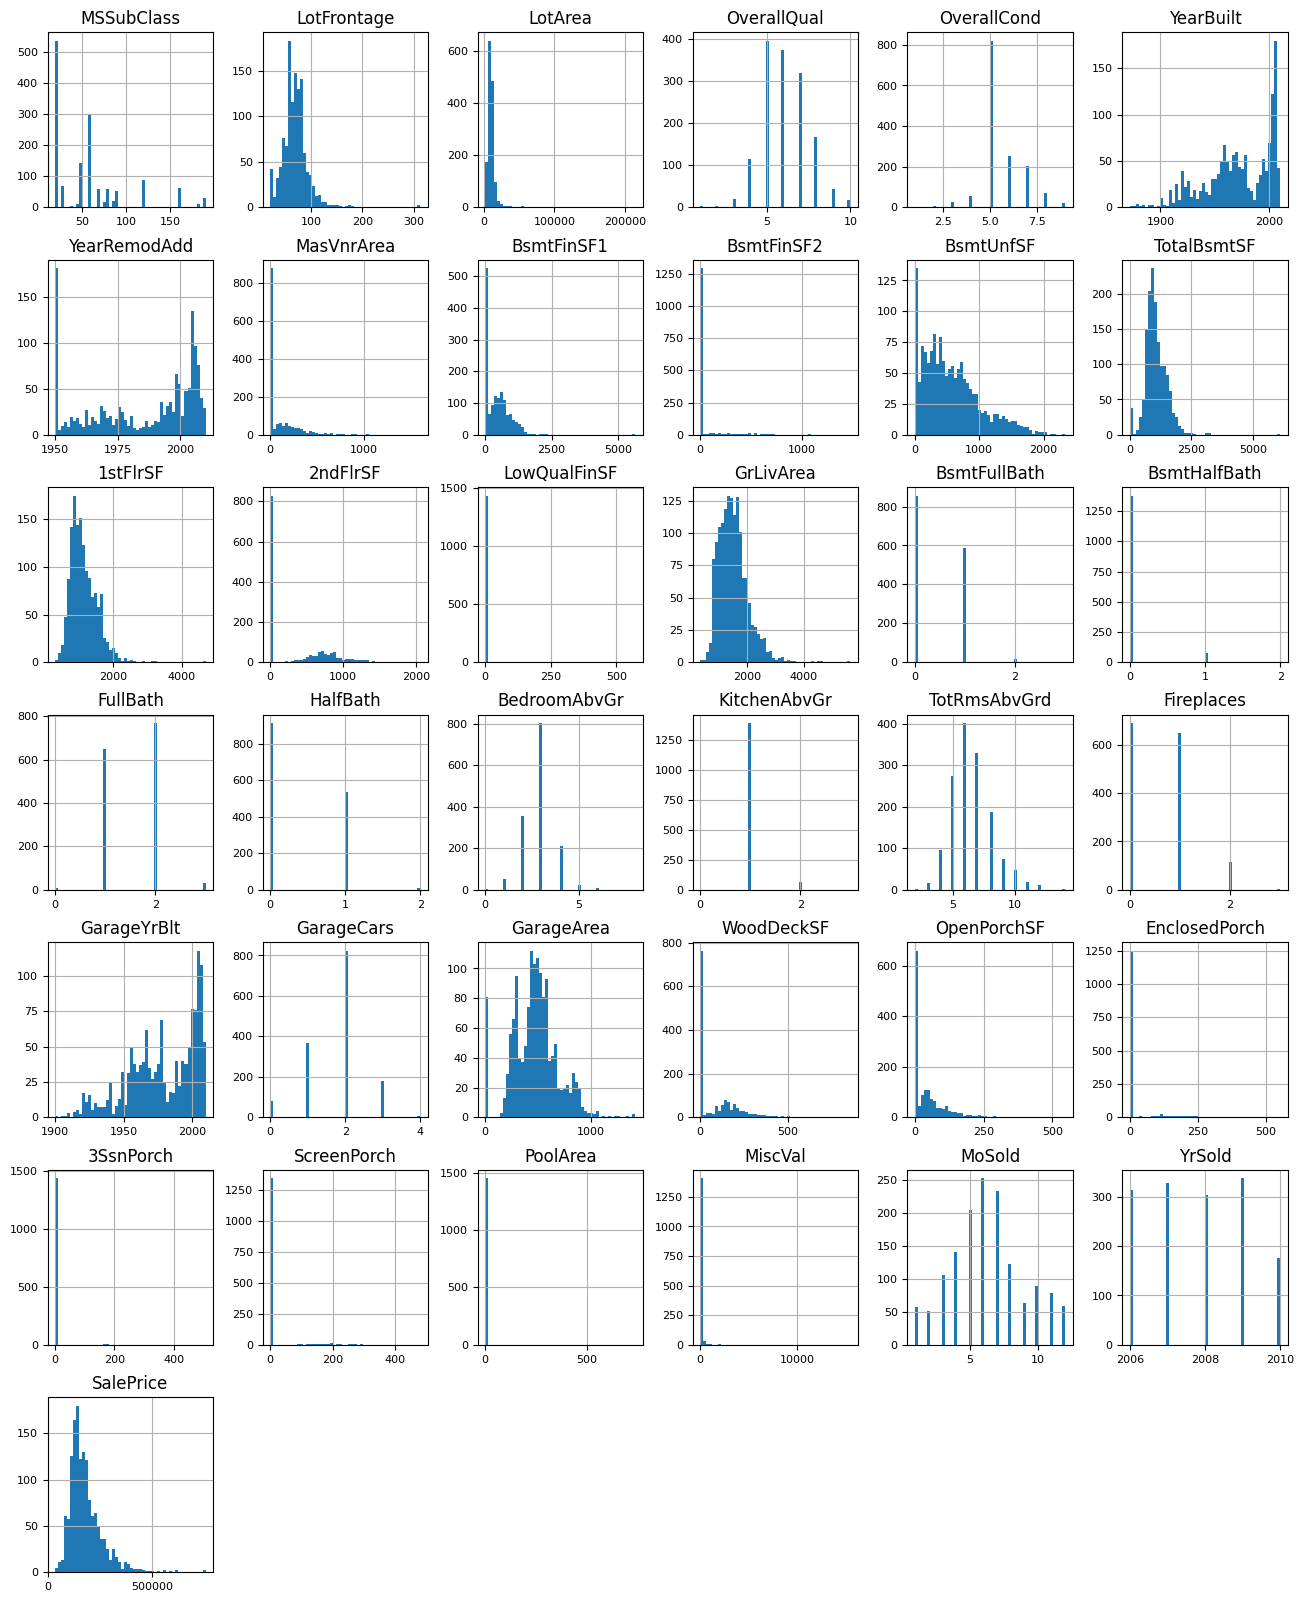

In [ ]:
dataframe_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Let's plot each numeric column and 'SalePrice' and see there is a linear relation between the two.

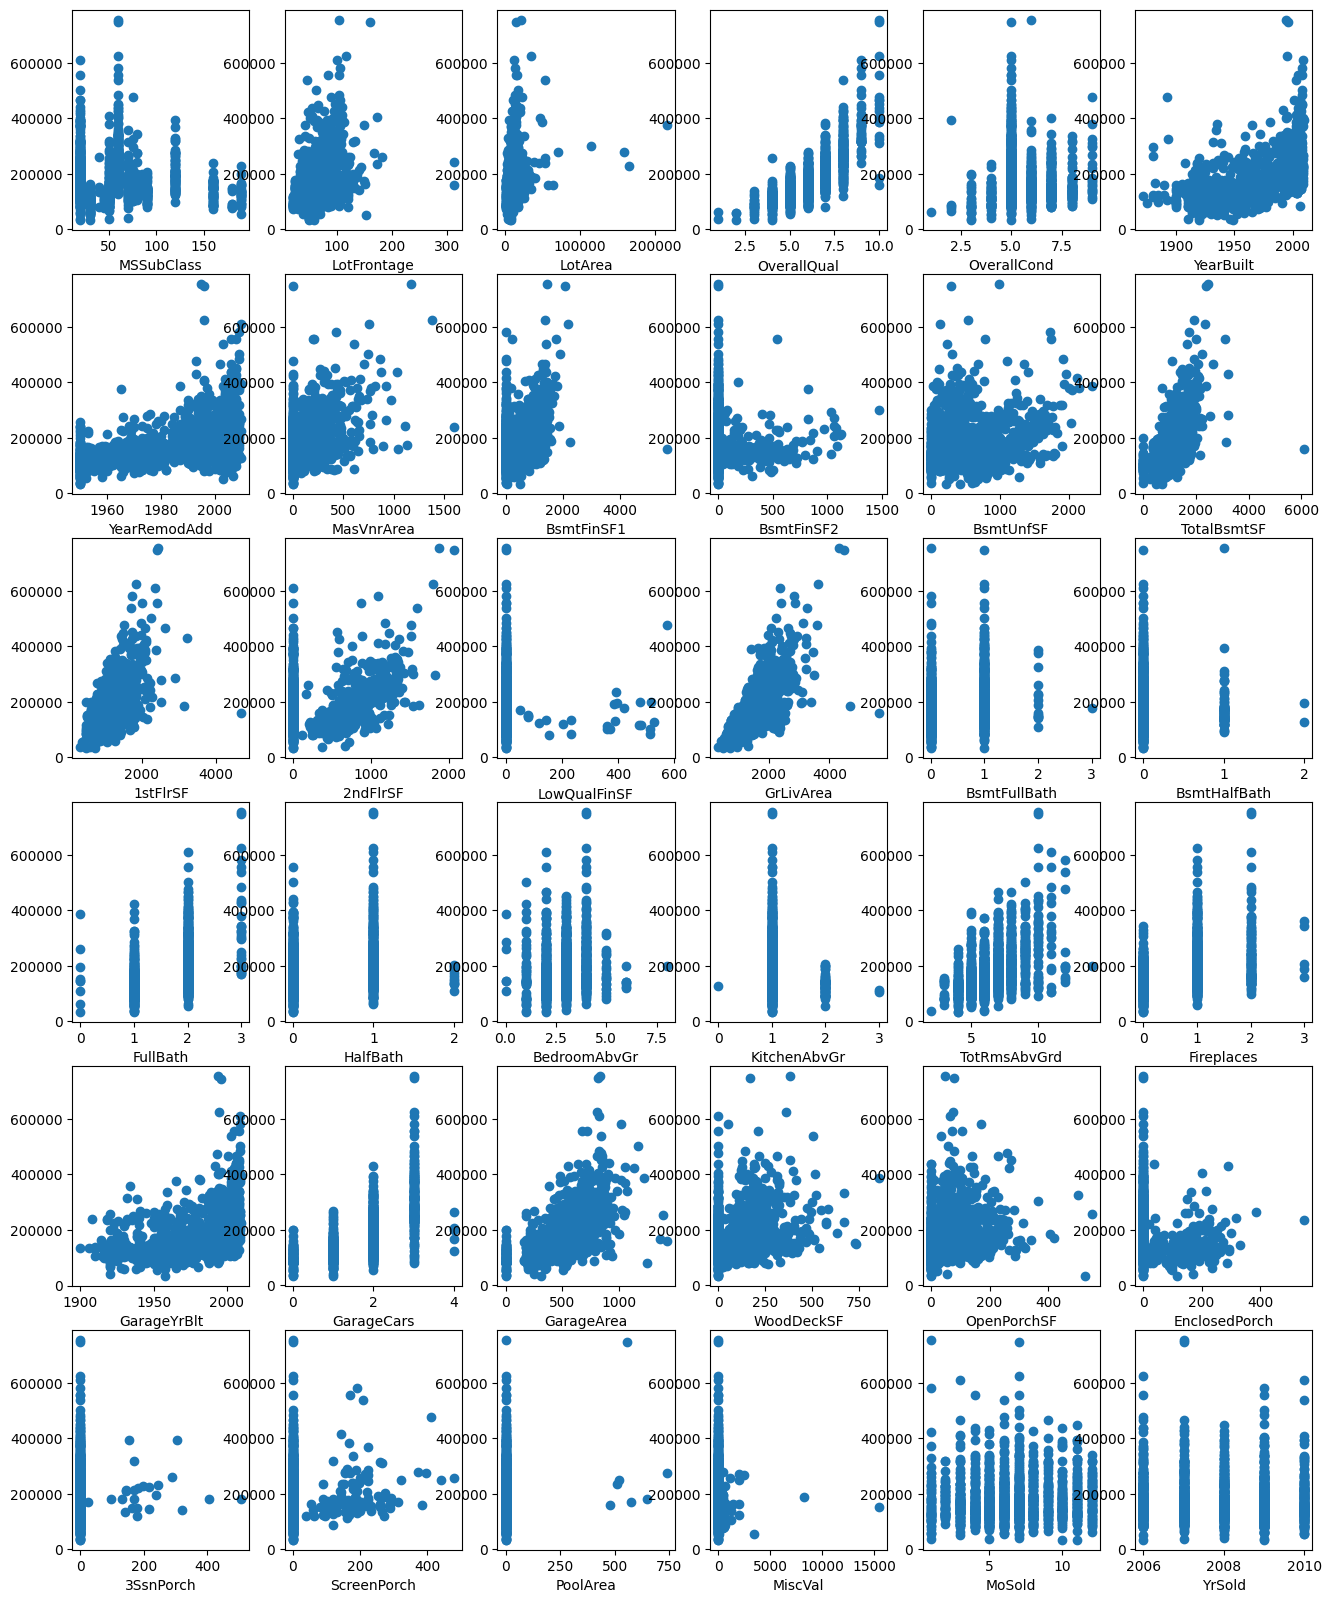

In [51]:
num_subplots = dataframe_num.columns.shape[0] - 1 # minus 'SalePrice' column
ncols = 6
nrows = math.ceil(num_subplots / ncols)
nrows, ncols
fig, ax= plt.subplots(nrows, ncols, figsize=[16,20])
for i, col in enumerate(dataframe_num.columns):
  if col == 'SalePrice': continue
  r, c = int(i / ncols), i % ncols
  ax[r,c].scatter(dataframe_num[col], dataframe['SalePrice'])
  # ax[r,c].set_ylabel('Sale Price')
  ax[r,c].set_xlabel(dataframe_num.columns[i])
plt.show()

Select the following columns that there is a linear relation with 'SalePrice'.

In [52]:
cols_num = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea']

Select the non-numeric columns and put them in a data frame.

In [11]:
dataframe_obj = dataframe.select_dtypes(include=[object])
dataframe_obj.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


## Preprocess Data

In [65]:
num_nans = dataframe.isna().sum().to_numpy()
dataframe.columns[num_nans != 0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [67]:
modes = dataframe.mode().iloc[0]
modes

MSSubClass           20
MSZoning             RL
LotFrontage        60.0
LotArea            7200
Street             Pave
                  ...  
MoSold                6
YrSold             2009
SaleType             WD
SaleCondition    Normal
SalePrice        140000
Name: 0, Length: 80, dtype: object

In [69]:
dataframe.fillna(modes, inplace=True)
dataframe.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal,250000


In [70]:
dataframe_num = dataframe.select_dtypes(include=['float64', 'int64'])
dataframe_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
dataframe_obj = dataframe.select_dtypes(include=[object])
cols = [col for col in dataframe_obj.columns.tolist() if col != 'SalePrice']
cols, len(cols)

(['MSZoning',
  'Street',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'Heating',
  'HeatingQC',
  'CentralAir',
  'KitchenQual',
  'Functional',
  'PavedDrive',
  'SaleType',
  'SaleCondition'],
 27)

In [ ]:
dataframe = pd.get_dummies(dataframe, columns=cols)
dataframe.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0,0,0,1,0,0,0,0,1,0


## Prepare Dataset

In [117]:
y = torch.tensor(dataframe['SalePrice'], dtype=torch.float)
y.shape, y.dtype

(torch.Size([1460]), torch.float32)

In [118]:
# x_cols = [c for c in dataframe.columns if c != 'SalePrice']
x_cols = ['OverallQual', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
n_coeffs = len(x_cols) + 1
X = torch.tensor(dataframe[x_cols].values, dtype=torch.float)
X.shape

torch.Size([1460, 5])

In [119]:
# Normalize X.
vals,indices = X.max(dim=0)
X = X / vals
X.shape, X[:3]

(torch.Size([1460, 5]),
 tensor([[0.7000, 0.9965, 0.1401, 0.1824, 0.3031],
         [0.6000, 0.9831, 0.2065, 0.2690, 0.2237],
         [0.7000, 0.9955, 0.1506, 0.1961, 0.3166]]))

In [79]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(dataframe)
len(trn_split), len(val_split)

(1168, 292)

In [120]:
X_train, X_valid = X[trn_split], X[val_split]
y_train, y_valid = y[trn_split], y[val_split]

X_train = torch.concatenate((X_train, torch.ones((len(trn_split), 1))), axis=1)
X_valid = torch.concatenate((X_valid, torch.ones((len(val_split), 1))), axis=1)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([1168, 6]),
 torch.Size([1168]),
 torch.Size([292, 6]),
 torch.Size([292]))

## Train Model (Baseline)

In [121]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [122]:
lin_reg.score(X_valid, y_valid)

0.7937651942645412

## Train Model (LLS)

In [128]:
# Return the coefficient of determination of the prediction.
# See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
def lin_score(y_pred, y_true):
  u = ((y_true - y_pred)**2).sum()
  v = ((y_true - y_true.mean()) ** 2).sum()
  return 1-(u/v)

In [125]:
# Ridge regression.
l = 0.5
w = torch.linalg.inv(X_train.T@X_train+l*torch.eye(n_coeffs))@(X_train.T@y_train.reshape((-1,1)))

In [127]:
y_pred = (X_valid@w).squeeze(axis=1)
y_pred.shape, y_pred.dtype

(torch.Size([292]), torch.float32)

In [150]:
print(f'score: {lin_score(y_pred, y_valid)}')

score: 0.7806311845779419


## Train Model (SGD)

In [90]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return ((calc_preds(coeffs, indeps)-deps)**2).mean()

In [91]:
def update_coeffs(coeffs, lr):
  coeffs.sub_(coeffs.grad * lr)
  coeffs.grad.zero_()

In [143]:
def one_epoch(coeffs, lr, idx):
    loss = calc_loss(coeffs, X_train, y_train)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    if idx % 100 == 0: print(f"Iter {idx}, {loss:.3f}", end="\n")

In [94]:
def init_coeffs(): return (torch.rand(n_coeffs)-0.5).requires_grad_()

In [140]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(42)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr, i)
    return coeffs

In [146]:
coeffs = train_model(5000, lr=0.1)

Iter 0, 38287269888.000
Iter 100, 3064480256.000
Iter 200, 2257996544.000
Iter 300, 1923436928.000
Iter 400, 1784044416.000
Iter 500, 1725439744.000
Iter 600, 1700338816.000
Iter 700, 1689184128.000
Iter 800, 1683878144.000
Iter 900, 1681060480.000
Iter 1000, 1679331072.000
Iter 1100, 1678102272.000
Iter 1200, 1677122304.000
Iter 1300, 1676281088.000
Iter 1400, 1675527552.000
Iter 1500, 1674835584.000
Iter 1600, 1674191232.000
Iter 1700, 1673584768.000
Iter 1800, 1673009920.000
Iter 1900, 1672461696.000
Iter 2000, 1671936512.000
Iter 2100, 1671430656.000
Iter 2200, 1670941568.000
Iter 2300, 1670467328.000
Iter 2400, 1670006144.000
Iter 2500, 1669555968.000
Iter 2600, 1669115904.000
Iter 2700, 1668684544.000
Iter 2800, 1668261120.000
Iter 2900, 1667844736.000
Iter 3000, 1667434752.000
Iter 3100, 1667030528.000
Iter 3200, 1666631680.000
Iter 3300, 1666237312.000
Iter 3400, 1665847424.000
Iter 3500, 1665461888.000
Iter 3600, 1665080192.000
Iter 3700, 1664702208.000
Iter 3800, 1664327424.0

In [148]:
y_pred = (X_valid@coeffs.reshape(-1, 1)).squeeze(axis=1)
y_pred.shape, y_pred.dtype
print(f'score: {lin_score(y_pred, y_valid)}')

score: 0.7806311845779419
